# Home Depot Product Search Relevance

## Description

### general description:

Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

### data description:

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

**The relevance is a number between 1 (not relevant) to 3 (highly relevant)**. For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

The specific instructions given to the raters is provided in relevance_instructions.docx.
Raters did not have access to the attributes.
Raters had access to product images, while the competition does not include images.
**Your task is to predict the relevance for each pair listed in the test set.**  
Note that the test set contains both seen and unseen search terms.

## General Exploration

imports relevant packages:

In [0]:
#!pip install matplotlib-venn # we will use this package to plot sets intersection

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib_venn as venn
import pickle

Populating the interactive namespace from numpy and matplotlib


read data:

In [0]:
path = './gdrive/My Drive/Work-3/Q2/'
train_df = pd.read_csv(path + 'data/train.csv', index_col='id', encoding = 'ISO-8859-1')
test_df = pd.read_csv(path + 'data/test.csv', index_col='id', encoding = 'ISO-8859-1')
attributes_df = pd.read_csv(path + 'data/attributes.csv', encoding = 'ISO-8859-1')
descriptions_df = pd.read_csv(path + 'data/product_descriptions.csv', encoding = 'ISO-8859-1')

In [0]:
print('train shape: {}\ntest shape: {} \nattributes shape: {} \ndescriptions shape: {}'.format(
    train_df.shape,test_df.shape,attributes_df.shape,descriptions_df.shape))

train shape: (74067, 4)
test shape: (166693, 3) 
attributes shape: (2044803, 3) 
descriptions shape: (124428, 2)


**Data fields**  
id - a unique Id field which represents a (search_term, product_uid) pair  
product_uid - an id for the products  
product_title - the product title  
product_description - the text description of the product (may contain HTML content)  
search_term - the search query  
relevance - the average of the relevance ratings for a given id  
name - an attribute name  
value - the attribute's value  
  
  
let's take a look at the dataframes we read:

In [0]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [0]:
descriptions_df.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [0]:
attributes_df.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [0]:
test_df.head()

,product_uid,product_title,search_term
id,,,
1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


** improtant facts we have to remember: **
* in general, the raters didn't have the attributes file (in kaggle they wrote that in some cases there was link for more details about the product, we we are not sure that all the details exist).  
* the raters rated the correlation between the query and the results by three main attributes: Brand, Material, and Functionality.  
* the raters mainly rated the correlation by an image (that we don't have) and the product title.  
  
let's look at the relevance distribution:

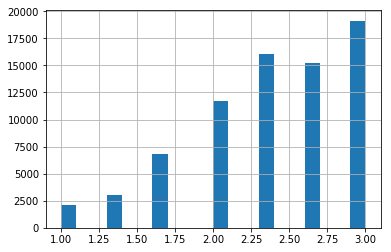

In [0]:
train_df.relevance.hist(bins=20)

let's look at some statistics about the relevance in train set:

In [0]:
train_relevance_vcounts = train_df.relevance.value_counts()
print(train_relevance_vcounts)
print('\n *** important to notice: *** \n\n precent of rounded rating: %.2f \n precent rated with 3.00: %.2f \n precent rated with 2.00: %.2f \n precent of rating >= 2: %.2f \n precent of rating >= 2.5: %.2f' % (
    (train_relevance_vcounts.get(3.00) + train_relevance_vcounts.get(2.00) + train_relevance_vcounts.get(1.00))/train_df.shape[0],
    train_relevance_vcounts.get(3.00)/train_df.shape[0],
    train_relevance_vcounts.get(2.00)/train_df.shape[0],
    train_relevance_vcounts.iloc[0:4].values.sum()/train_df.shape[0],train_relevance_vcounts.iloc[0:3].values.sum()/train_df.shape[0]))

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

 *** important to notice: *** 

 precent of rounded rating: 0.45 
 precent rated with 3.00: 0.26 
 precent rated with 2.00: 0.16 
 precent of rating >= 2: 0.84 
 precent of rating >= 2.5: 0.68


we can also notice that there are only 13 different ratings, this is makes sense because in most of the cases there were only 3 raters, that rated 1,2,3. so therefore there is a closed area of values. but because the evaluation is by rmse we decided to handle it as regression problem. (also we don't want to treat every mistake in the same way)

### check for null values

In [0]:
train_df.isnull().any()

product_uid      False
product_title    False
search_term      False
relevance        False
dtype: bool

In [0]:
descriptions_df.isnull().any()

product_uid            False
product_description    False
dtype: bool

In [0]:
test_df.isnull().any()

product_uid      False
product_title    False
search_term      False
dtype: bool

In [0]:
attributes_df.isnull().any()

product_uid    True
name           True
value          True
dtype: bool

let's take a look on the attributes rows with Nans:

In [0]:
attributes_df[attributes_df.isnull().any(axis=1)].iloc[:10]

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
1929,NaN,NaN,NaN
4094,NaN,NaN,NaN
4100,NaN,NaN,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
6823,NaN,NaN,NaN
7898,100329.0,Fastener recommendation,NaN
7901,100329.0,MFG Brand Name,NaN


** to conclude: **
* train, test and description sets dont include Nans values.
* features include Nans (can also be all the row with Nan)

### explore the search term  
the search term was written by users in the site, hence it is very prone to trouble because it is open and any user can choose how to fill it, so we have to analyze if there are common spelling mistakes, signs and etc.

In [0]:
train_df.search_term[:200]

id
2                                angle bracket
3                                    l bracket
9                                    deck over
16                            rain shower head
17                          shower only faucet
18                              convection otr
20                        microwave over stove
21                                  microwaves
23                             emergency light
27                                     mdf 3/4
34                                steele stake
35              briggs and stratton lawn mower
37                                    gas mowe
38                                 honda mower
48          hampton bay chestnut pull up shade
51                                    disposer
65                                grill gazebo
69                                 door guards
75                      metal plate cover gcfi
81                              radiator grate
85                             windows screens
88        

In [0]:
def save_obj(obj, name):
    with open(path + 'obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(path + 'obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

the code below was taken from kaggle forum:

In [0]:
import requests
import re
import time
from random import randint

START_SPELL_CHECK = '<a class="gL9Hy" href="/search?'
END_SPELL_CHECK='</i></b></a><br><span class="spell_orig">'
HTML_Codes = (("'", '&#39;'),('"', '&quot;'),('>', '&gt;'),('<', '&lt;'),('&', '&amp;'))

def spell_check(s):
    q = '+'.join(s.split())
    time.sleep(  randint(0,1) ) #relax and don't let google be angry
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        if end==-1:
            end=content.find('&amp;hl=iw&amp;sa=X&amp;as_q=&amp;nfpr=&amp;spell=1&amp;')
        search= content[start:end]
        #search = search[search.find('>')+1:]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
    else:
        search = s
    return search ;

In [0]:
spelling_mistakes = {}
for sentence in train_df.search_term.values[:1000]:
    correction = spell_check(sentence)
    if sentence != correction:
        spelling_mistakes[sentence] = correction

In [0]:
spelling_mistakes = load_obj('sp_mistakes')

In [0]:
len(spelling_mistakes)

3364

as we can see there are 3364 search terms with spelling mistakes. (this is 4%)

length of term statistics:

In [0]:
len_train = train_df.search_term.apply(lambda x: len(x.split()))
print('max length: {} \nmin length: {} \nmean length: {}'.format(len_train.max(),len_train.min(),round(len_train.mean())))

max length: 14 
min length: 1 
mean length: 3.0


check number of digit in search term:

In [0]:
def digit_count(words):
    sum = 0
    for w in words:
        for ch in w:
            if ch.isnumeric():
                sum += 1
    return sum

In [0]:
print('avg number of digits in one search term: {}'.format(
    train_df.search_term.apply(lambda x: digit_count(x.split())).mean()))

avg number of digits in one search term: 0.6485479363279193


let's take a look which punctuations 'search_term' consist:

In [0]:
# data - array of strings
# print count for each punctuation character
from string import punctuation as _punctuation
def punctuation_ch_counts(data):
    total_ch = 0
    threaded_search_term = ''
    for x in data:
        threaded_search_term += ' ' + x
        total_ch += len(x)
    punc_search_term = list(set(re.sub('[^' + _punctuation + ']+','', threaded_search_term)))
    print(punc_search_term)
    counter_punc_st = [0] * len(punc_search_term)
    for sentence in data:
        for idx in range(len(sentence)):
            for i in range(len(punc_search_term)):
                if punc_search_term[i] == sentence[idx]:
                    counter_punc_st[i] += 1
    ans = sorted([(punc_search_term[index],counter_punc_st[index]) for index in range(len(punc_search_term))], key= lambda x: x[1])
    for el in ans:
        print('punctuation: {}  appear: {} times'.format(el[0],el[1]))
    print('total characters: {}'.format(total_ch))
    return ans

In [0]:
punc_lst = punctuation_ch_counts(train_df.search_term.values)

[';', ',', '-', '~', '$', "'", ':', '=', '/', '*', '?', '&', '_', '.']
punctuation: ~  appear: 2 times
punctuation: =  appear: 3 times
punctuation: :  appear: 5 times
punctuation: _  appear: 8 times
punctuation: ?  appear: 15 times
punctuation: ;  appear: 38 times
punctuation: $  appear: 56 times
punctuation: *  appear: 81 times
punctuation: &  appear: 82 times
punctuation: ,  appear: 414 times
punctuation: '  appear: 1107 times
punctuation: .  appear: 1508 times
punctuation: -  appear: 2044 times
punctuation: /  appear: 3402 times
total characters: 1407926


In [0]:
def get_words_consist_ch(data,ch):
    ans = []
    for sentence in data:
        for word in sentence.split():
            if ch in word:
                ans.append(word)
    return ans

def create_punc_df(punc_lst, data):
    punc_lst = punc_lst[::-1]
    dic_punc = {}
    for p in punc_lst:
        dic_punc[p] = pd.Series(get_words_consist_ch(data,p))
    return pd.DataFrame(dic_punc)

example for each punctuation:

In [0]:
create_punc_df([x for (x,y) in punc_lst], train_df.search_term.values)[:100].transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$,$100,$,$,$289.00,$100,4x$,$100,$289.00,$100,10$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
&,&,&,&,&,&,b&d,&,&,&,&,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
',30','molded,18',24',3',6',21',15',3/4',insulation',...,11',25',3/4',7-1/2',12',24',3/4',16',12',30'
(,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
*,4*8,12*12,2*3,4*8,*,4*8,4*8,64*12,13x1-1/2*,64*12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** we can notice that: **  
* there are some terms with a mix of digits and characters, such as 'm6 screw 90mm' ,  'restore 4x' 
* the characters sometimes uppercase and sometimes not. 'tv riser glass' vs 'PLATFORM FOR WASHERS'  
* there are spelling mistakes. 'glacier bay tiolet tank lid' (tiolet shold be toilet)
* repeated words without space. ('lightlight')
* length of the term is varied. (as we can see above)
* in average there is less than one digit in search term.
* some punctuation doesn't appear or appear rarely. other appear more often, most of them to indicate measurment.

### Explore description

In [0]:
descriptions_df.product_description[:10].values

array(['Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws',
       'BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. 

length of description statistics:

In [0]:
len_desc = descriptions_df.product_description.apply(lambda x: len(x.split()))
print('max length: {} \nmin length: {} \nmean length: {}'.format(len_desc.max(),len_desc.min(),round(len_desc.mean())))

max length: 889 
min length: 1 
mean length: 127.0


check number of digit in product description:

In [0]:
print('avg number of digits in one product description: {}'.format(
    descriptions_df.product_description.apply(lambda x: digit_count(x.split())).mean()))

avg number of digits in one product description: 12.64166425563378


let's look which punctuation description consist:

In [0]:
punc_lst = punctuation_ch_counts(descriptions_df.product_description.values)

['-', ']', "'", '+', '=', ';', '(', '"', '/', '^', '{', '?', '*', '&', '[', ',', '$', '#', ':', '!', '`', '_', '}', '<', '@', '>', ')', '.', '%']
punctuation: ^  appear: 7 times
punctuation: >  appear: 13 times
punctuation: {  appear: 14 times
punctuation: }  appear: 14 times
punctuation: `  appear: 21 times
punctuation: [  appear: 102 times
punctuation: ]  appear: 114 times
punctuation: @  appear: 209 times
punctuation: <  appear: 296 times
punctuation: *  appear: 381 times
punctuation: =  appear: 1270 times
punctuation: _  appear: 1361 times
punctuation: !  appear: 1586 times
punctuation: ?  appear: 2101 times
punctuation: $  appear: 2174 times
punctuation: +  appear: 2869 times
punctuation: #  appear: 6325 times
punctuation: "  appear: 9306 times
punctuation: %  appear: 26832 times
punctuation: &  appear: 27294 times
punctuation: ;  appear: 44088 times
punctuation: '  appear: 55341 times
punctuation: (  appear: 76716 times
punctuation: )  appear: 76786 times
punctuation: :  appear: 

example for each punctuation:

In [0]:
create_punc_df([x for (x,y) in punc_lst], descriptions_df.product_description.values)[:100].transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
!,guide!WARNING:,included!,comfortably!,gazebo!Vented,guide!WARNING:,guide!,today!,USA!Great,guide!WARNING:,costs!,...,tools!,drawer!,guide!WARNING:,use!,kitchen!,Project!,items!,up!Peel,overnight!,in!
"""","""Z""","deck""Quick","connect""","collection""","""Rubber","use.""100%","""We","You""","""We","You""",...,"Specifications4""","""More","Info""","""Specifications""","""perfect","cut""","""wall","walking""Quick","""Z""","users""E"""
#,#9,#10,#1,"#73014884),","#73014886),",#73014885)5,#73014080)Vinyl,#,#,#1,...,#,#,#s,#204512712,#,#203227252,#203227258,#209,#1,model#
$,$3.85,$187,$1.57,"cord$50,000",$4.82,$2.05,$60.Steel,$60,$3.85,$4500,...,$4.40,"$250,000","mounting$250,000",$88,$1.69,$77.00,$.60(based,$10,$100,$1.14
%,100%,sidewalks100%,19%),loads100%,99.9%,97%,97%,propane99.9%,100%,(100%,...,gates30%,100%,100%,0%,20%,50%,50%,100%,100%,100%
&,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition,&,see&nbsp;Proposition,&,&,see&nbsp;Proposition,&,see&nbsp;Proposition,...,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition,&,see&nbsp;Proposition,see&nbsp;Proposition,see&nbsp;Proposition
',you'll,won't,favoritesKids',it's,it's,Kids',don't,that's,turntable's,don't,...,blower's,Product's,Clay's,Clay's,clay's,clay's,fan's,Depot's,sun's,sun's
(,(skewed),(look,(approximately,(0,(R10000-UNBX),(recirculating),(120,(90-Pack),(not,(not,...,(based,(daylight)Energy,(Roto-Stop),(2-Pack),(Americans,(black,(micronized,(black,light(s),(model
),(skewed),number).Versatile,19%),+5-Watt)Anti-reflective,(R10000-UNBX),(recirculating),277-volt)Easily,(90-Pack),included),included).,...,(daylight)Energy,(Roto-Stop),(2-Pack),Act),iron),azoles),iron),light(s),EVFIK),(UWO)
*,*Size,**Assembly,required**Weight:,**Assembly,required**Cargo,**Assembly,required**Weight:,(E)*,color.*Size,**Assembly,...,easy.*Size,options*Size,90*,(E)*,500*300D,500*300D,(E*),90*,(E)*,(E)*


# ** we can notice that the description incdluded: ** 
* digits and characters.
* uppercase and lowercase.
* HTML tags ('see&nbsp;')
* 2 different words without space. ('sidewalks100%')
* length of the description is varied. (as we can see above)
* in avg there is ~13 digits in one product description. (it means that in avg ~1% of the product description is digits)

### merging sets  
let's merge product description from description set to the train and test sets:

In [0]:
train_desc_df = train_df.merge(descriptions_df, on='product_uid',right_index = True)
test_desc_df = test_df.merge(descriptions_df, on='product_uid', right_index = True)

In [0]:
print('****train****')
print(train_desc_df.shape)
display(train_desc_df.head())
print('****test****')
print(test_desc_df.shape)
display(test_desc_df.head())

****train****
(74067, 5)


,product_uid,product_title,search_term,relevance,product_description
id,,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


****test****
(166693, 4)


,product_uid,product_title,search_term,product_description
id,,,,
1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


save the merged sets:

In [0]:
train_desc_df.to_csv(path + 'data/train_merged.csv', index_label='id', encoding = 'ISO-8859-1')
test_desc_df.to_csv(path + 'data/test_merged.csv', index_label='id', encoding = 'ISO-8859-1')

Explore the similarity between the train and test sets  
we will explore the similarity in the following ways:  
* length of each corresponding column.
* common words for each corresponding column.  
  
we wil start with the first one:

Text(0.5,1,'test')

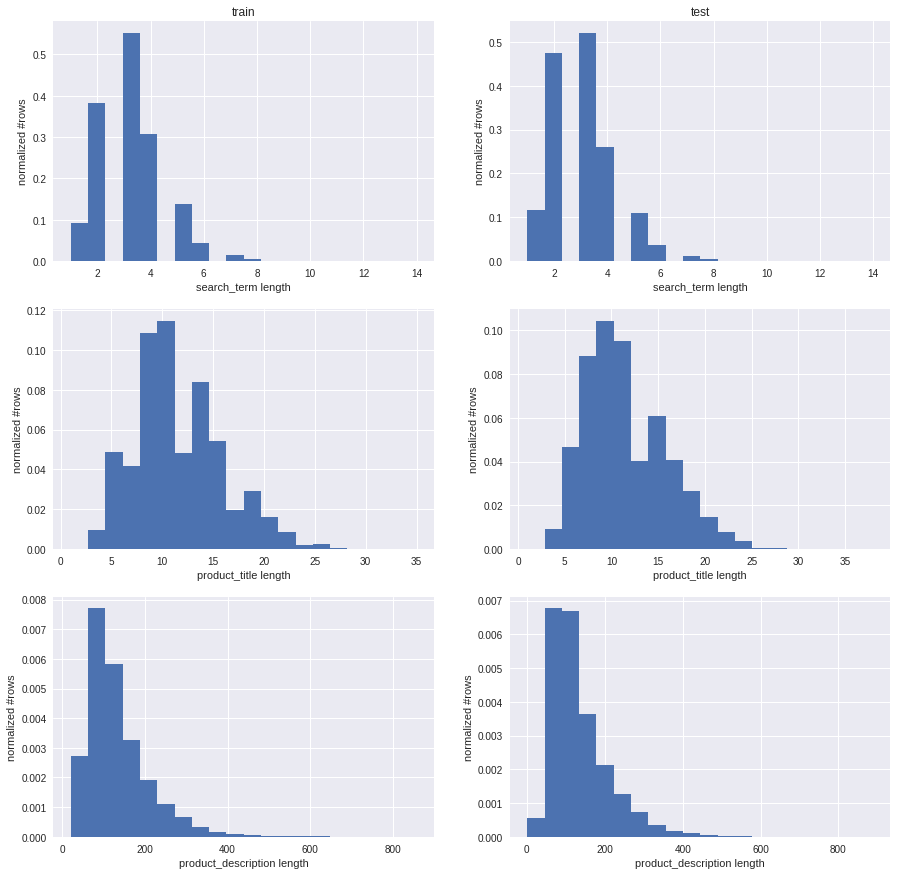

In [0]:
predictors = ['search_term', 'product_title', 'product_description']
fig, ax = plt.subplots(figsize=(15,15), nrows=len(predictors), ncols=2)
for i, feat in enumerate(predictors):
    for j, df in enumerate([train_desc_df, test_desc_df]):
        ax[i][j].hist(df[feat].apply(lambda x: len(x.split())), normed=True, bins=20) # normed=True is important because different number of rows in train and test
        ax[i][j].set_xlabel(feat + ' length')
        ax[i][j].set_ylabel('normalized #rows')
ax[0][0].set_title('train')
ax[0][1].set_title('test')

*** we can notice that: ***
* the distribution of length is similar (and almost identical) in both train and test sets.

let's check for common words:

In [0]:
def most_freq_words(words):
    vec = CountVectorizer(stop_words = {'English'},ngram_range = (1,3)).fit(words)
    bow = vec.transform(words)
    words_count = bow.sum(axis=0)
    words_freq = [(word, np.squeeze(np.asarray(words_count))[idx]) for (word,idx) in vec.vocabulary_.items()] # vec.vocabulary_.items() dict items of tuple consist word and column idx 
    return sorted(words_freq, key = lambda x: x[1], reverse=True)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['english'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Text(0.5,1,'test')

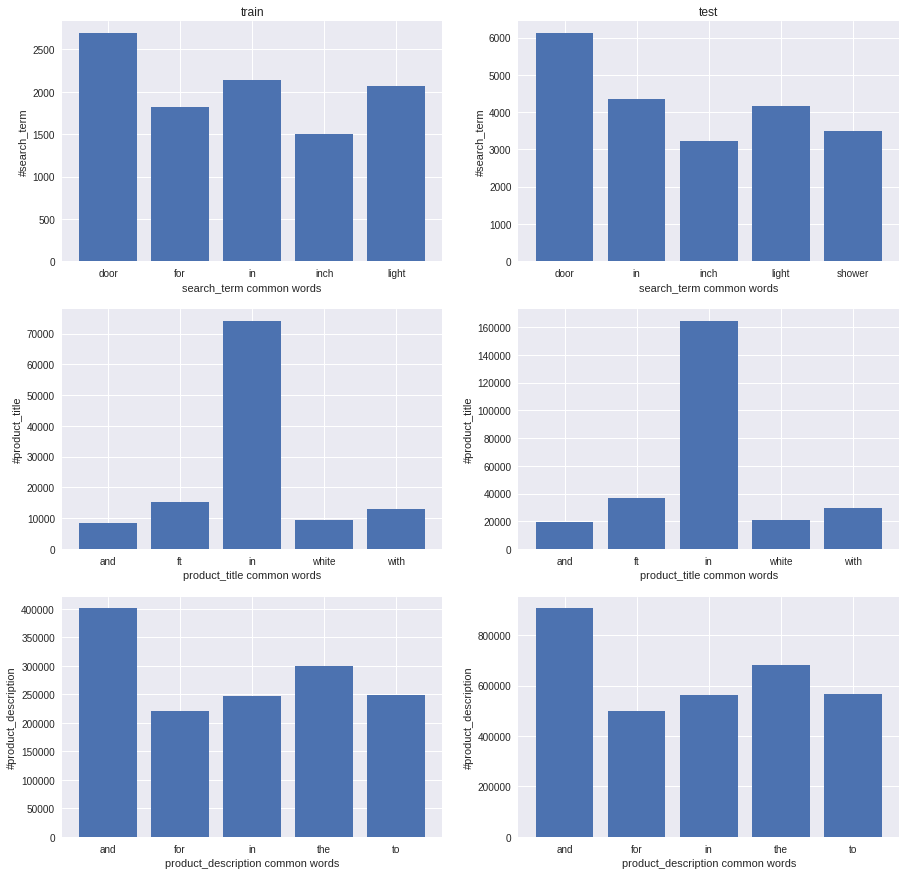

In [0]:
predictors = ['search_term', 'product_title', 'product_description']
fig, ax = plt.subplots(figsize=(15,15), nrows=len(predictors), ncols=2)
for i, feat in enumerate(predictors):
    for j, df in enumerate([train_desc_df, test_desc_df]):
        best_5_lst = most_freq_words(df[feat].values)[:5]
        x = [x[0] for x in best_5_lst]
        y = [x[1] for x in best_5_lst]
        ax[i][j].bar(x,y)
        ax[i][j].set_xlabel(feat + ' common words')
        ax[i][j].set_ylabel('#' + feat)
ax[0][0].set_title('train')
ax[0][1].set_title('test')

*** we can notice that: ***  
* common words in 'product_title' and 'product description' are the same with the same order in both train and test sets.
* 'search_term' common words are very similar both consist the words: door,in,inch and light. while 'for' appear only in the train and 'shower' only in the test top-5-common words. (we check and these words appear as the sixth word of the most common words for 'search_term')  

let's examine how many products exist in both the train and test set:

Text(0.5,1,'Search_term venn diagram')

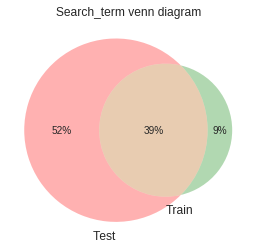

In [0]:
set_testId = set(test_desc_df.search_term.values)
set_trainId = set(train_desc_df.search_term.values)
total = len(set_testId) + len(set_trainId) - len(set_testId.intersection(set_trainId))
venn.venn2([set_testId, set_trainId],['Test','Train'], alpha=0.3, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
plt.title('Search_term venn diagram')

124428


Text(0.5,1,'product_uid venn diagram')

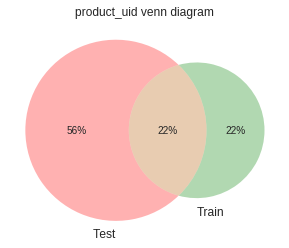

In [0]:
set_testId = set(test_desc_df.product_uid.values)
set_trainId = set(train_desc_df.product_uid.values)
total = len(set_testId) + len(set_trainId) - len(set_testId.intersection(set_trainId))
print(total)
venn.venn2([set_testId, set_trainId],['Test','Train'], alpha=0.3, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
plt.title('product_uid venn diagram')

In [0]:
te = [x[0] for x in test_df[['product_uid']].values]
tr = [x[0] for x in train_df[['product_uid']].values]
ans = [x for x in te if x not in tr]
ans2 = [x for x in tr if x not in te]
ans3 = [x for x in te if x in tr]
ans4 = [x for x in tr if x in te]


In [0]:
len(set(ans))

69761

In [0]:
len(set(ans))/(len(te) + len(tr))

0.28975328127595945

* as we can notice, 56% of the products and 52% of the search terms are different from the products and search terms in the train set.
* only 39% of search terms and 22% of products exist in both of the sets.

this facts may influence the way we split the train data to valdiation set.

### Explore attributes:  
let's check the most 20 common words in attributes name:

In [0]:
most_freq_words(attributes_df.fillna('None').name.values)[:40]

[('in', 368021),
 ('product', 302840),
 ('type', 177099),
 ('width', 111167),
 ('color', 106861),
 ('width in', 106185),
 ('height', 97215),
 ('height in', 92129),
 ('name', 90701),
 ('brand', 88355),
 ('depth', 87765),
 ('mfg', 86250),
 ('mfg brand', 86250),
 ('brand name', 86250),
 ('mfg brand name', 86250),
 ('bullet02', 86248),
 ('bullet03', 86226),
 ('bullet04', 86174),
 ('bullet01', 85940),
 ('depth in', 82378),
 ('family', 66037),
 ('finish', 64772),
 ('material', 62537),
 ('product width', 62429),
 ('product width in', 62273),
 ('bullet05', 60529),
 ('product height', 55396),
 ('assembled', 55373),
 ('product height in', 55313),
 ('product depth', 53918),
 ('product depth in', 53918),
 ('lb', 52717),
 ('product type', 52404),
 ('weight', 51447),
 ('color family', 48623),
 ('length', 46997),
 ('weight lb', 46679),
 ('product weight', 45914),
 ('product weight lb', 45210),
 ('bullet06', 44901)]

as we can see by looking at the most common attributes names and the attributes set the most common attributes are:
* width
* color
* product type
* height
* mfg brand name
* depth
* material
* type
* weight

In [0]:
train_df.loc[74068].product_title

'Aston Cascadia 25 in. x 72 in. Completely Frameless Hinged Shower Door in Chrome with Clear Glass'